In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import lightgbm as lgb
from catboost import CatBoostClassifier
import warnings
import zipfile

warnings.filterwarnings('ignore')

%matplotlib inline

# Set random seeds for reproducibility
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)

set_seed()

In [2]:
zip_file_path = '../data/transaction_data.csv.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    csv_file_name = 'transaction_data.csv'  
    zip_ref.extract(csv_file_name, path='../data/extracted/')

df = pd.read_csv('../data/extracted/transaction_data.csv')

X_train_df, X_test_df = train_test_split(df, test_size=0.25, random_state=42)

X_train_df.drop("Unnamed: 0", axis=1, inplace=True)
X_test_df.drop("Unnamed: 0", axis=1, inplace=True)

y_train = X_train_df['Class']
X_train = X_train_df.drop('Class', axis=1)
y_test = X_test_df['Class']
X_test = X_test_df.drop('Class', axis=1)

for col in X_train.columns:
    print(repr(col))

'V1'
'V2'
'V3'
'V4'
'V5'
'V6'
'V7'
'V8'
'V9'
'V10'
'V11'
'V12'
'V13'
'V14'
'V15'
'V16'
'V17'
'V18'
'V19'
'V20'
'V21'
'V22'
'V23'
'V24'
'V25'
'V26'
'V27'
'V28'
'Amount'


In [3]:
class LogAndScaleTransformer(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn transformer that log-transforms and scales numeric features,
    particularly suited for transaction data with 'Amount' columns.

    This transformer:
        1. Optionally creates a new column, 'Amount_log', defined as log1p('Amount'),
           which can mitigate skew in monetary transactions.
        2. Optionally drops the original 'Amount' column to avoid duplication.
        3. Identifies all numeric columns during fit, then fits a StandardScaler
           on those columns.
        4. Applies the same scaling parameters to new data at transform time,
           ensuring consistent handling across training and testing splits.

    Parameters:
        drop_original_amount : bool, default=True
            If True, the original 'Amount' column is dropped after computing 'Amount_log'.
            Set this to False if you wish to retain both columns in the output dataset.

    Attributes:
        scaler : StandardScaler
            The fitted StandardScaler instance used to scale numeric columns.

        numeric_cols_ : list of str
            A list of column names identified as numeric at fit time.
            Only these columns are scaled during transform.

    Notes:
    - This transformer inherits from scikit-learn's BaseEstimator and TransformerMixin,
      so it integrates seamlessly into pipelines and grid searches.
    - If the 'Amount' column is absent, the transformer will simply skip the log step.
      Attempting to scale columns identified at fit time but missing at transform time
      is likewise skipped gracefully.
    - The StandardScaler instance (self.scaler) is fit only once on the training data,
      then re-used on any subsequent data. This design prevents data leakage in
      production environments.
    """

    def __init__(self, drop_original_amount=True):
        self.drop_original_amount = drop_original_amount
        self.scaler = None
        self.numeric_cols_ = None

    def fit(self, X, y=None):
        """
        Fits the transformer to the training data, creating 'Amount_log' if applicable,
        dropping the 'Amount' column if requested, and identifying numeric columns
        for scaling.

        Parameters:
            X : pd.DataFrame
                The training data to fit the transformer on.
            y : pd.Series, optional
                Ignored; present for API consistency.

        Returns:
            LogAndScaleTransformer
                The fitted transformer (self), after learning the scaling parameters
                from the training data.
        """
        X_ = X.copy()

        # (1) Create 'Amount_log' if 'Amount' exists
        if 'Amount' in X_.columns:
            X_['Amount_log'] = np.log1p(X_['Amount'])

        # (2) Optionally drop the original 'Amount'
        if self.drop_original_amount and 'Amount' in X_.columns:
            X_.drop('Amount', axis=1, inplace=True)

        # (3) Identify numeric columns
        self.numeric_cols_ = X_.select_dtypes(include=[np.number]).columns.tolist()

        # (4) Fit StandardScaler on these columns
        self.scaler = StandardScaler()
        self.scaler.fit(X_[self.numeric_cols_])

        return self

    def transform(self, X, y=None):
        """
        Transforms new data by applying the same log transformation and scaling
        learned in the fit method. Will skip columns that do not exist in the new data
        or that are missing at transform time.

        Parameters:
            X : pd.DataFrame
                The new data to transform, typically the test set or additional inference data.
            y : pd.Series, optional
                Ignored; present for API consistency.

        Returns:
            pd.DataFrame
                A copy of X with 'Amount_log' created (if applicable) and numeric columns scaled
                according to the parameters fitted on the training data.
        """
        X_ = X.copy()

        # (1) Create 'Amount_log' if 'Amount' exists
        if 'Amount' in X_.columns:
            X_['Amount_log'] = np.log1p(X_['Amount'])

        # (2) Optionally drop the original 'Amount'
        if self.drop_original_amount and 'Amount' in X_.columns:
            X_.drop('Amount', axis=1, inplace=True)

        # (3) Apply scaling to numeric_cols_
        for col in self.numeric_cols_:
            if col not in X_.columns:
                continue  # skip if missing at transform time
        X_[self.numeric_cols_] = self.scaler.transform(X_[self.numeric_cols_])

        return X_

=== Random Forest ===
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     71089
           1     0.9556    0.7611    0.8473       113

    accuracy                         0.9996     71202
   macro avg     0.9776    0.8805    0.9235     71202
weighted avg     0.9996    0.9996    0.9995     71202



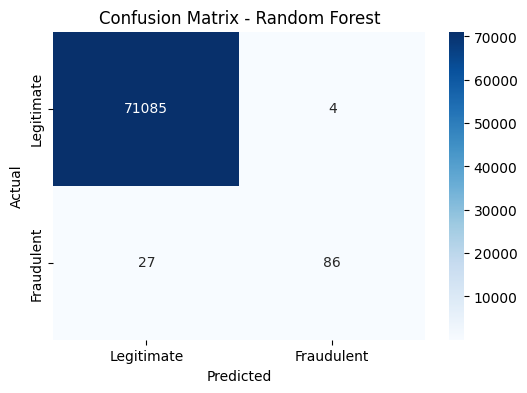

In [4]:
rf_pipe = Pipeline([
    ('logscale', LogAndScaleTransformer(drop_original_amount=True)),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ))
])

rf_pipe.fit(X_train, y_train)
rf_preds = rf_pipe.predict(X_test)

print("=== Random Forest ===")
cm_rf = confusion_matrix(y_test, rf_preds)
print(classification_report(y_test, rf_preds, digits=4))

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate','Fraudulent'],
            yticklabels=['Legitimate','Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Random Forest')
plt.show()

[LightGBM] [Info] Number of positive: 379, number of negative: 213226
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 213605, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001774 -> initscore=-6.332572
[LightGBM] [Info] Start training from score -6.332572
=== LightGBM ===
[[68552  2537]
 [   14    99]]
              precision    recall  f1-score   support

           0     0.9998    0.9643    0.9817     71089
           1     0.0376    0.8761    0.0720       113

    accuracy                         0.9642     71202
   macro avg     0.5187    0.9202    0.5269     71202
weighted avg     0.9983    0.9642    0.9803     71202



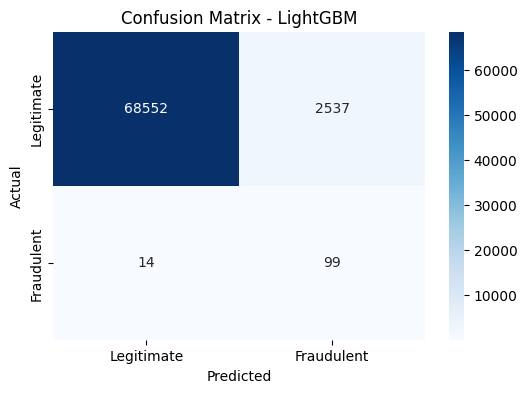

In [5]:
lgb_clf = lgb.LGBMClassifier(
    is_unbalance=True,
    n_jobs=-1,
    random_state=42
)

lgb_pipe = Pipeline([
    ('logscale', LogAndScaleTransformer(drop_original_amount=True)),
    ('lgb', lgb_clf)
])

lgb_pipe.fit(X_train, y_train)
lgb_preds = lgb_pipe.predict(X_test)

print("=== LightGBM ===")
cm_lgb = confusion_matrix(y_test, lgb_preds)
print(cm_lgb)
print(classification_report(y_test, lgb_preds, digits=4))

plt.figure(figsize=(6,4))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate','Fraudulent'],
            yticklabels=['Legitimate','Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - LightGBM')
plt.show()

=== CatBoost ===
[[71052    37]
 [   17    96]]
              precision    recall  f1-score   support

           0     0.9998    0.9995    0.9996     71089
           1     0.7218    0.8496    0.7805       113

    accuracy                         0.9992     71202
   macro avg     0.8608    0.9245    0.8901     71202
weighted avg     0.9993    0.9992    0.9993     71202



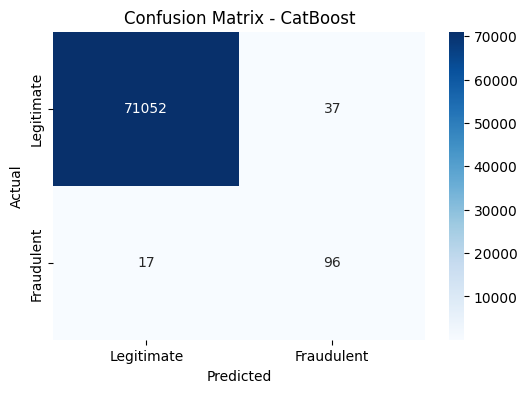

In [6]:
cat_clf = CatBoostClassifier(
    auto_class_weights='Balanced',
    thread_count=-1,
    iterations=100,
    verbose=False,
    random_state=42
)

cat_pipe = Pipeline([
    ('logscale', LogAndScaleTransformer(drop_original_amount=True)),
    ('cat', cat_clf)
])

cat_pipe.fit(X_train, y_train)
cat_preds = cat_pipe.predict(X_test)

print("=== CatBoost ===")
cm_cat = confusion_matrix(y_test, cat_preds)
print(cm_cat)
print(classification_report(y_test, cat_preds, digits=4))

plt.figure(figsize=(6,4))
sns.heatmap(cm_cat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate','Fraudulent'],
            yticklabels=['Legitimate','Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - CatBoost')
plt.show()

=== Isolation Forest ===
[[68332  2757]
 [   18    95]]
              precision    recall  f1-score   support

           0     0.9997    0.9612    0.9801     71089
           1     0.0333    0.8407    0.0641       113

    accuracy                         0.9610     71202
   macro avg     0.5165    0.9010    0.5221     71202
weighted avg     0.9982    0.9610    0.9786     71202



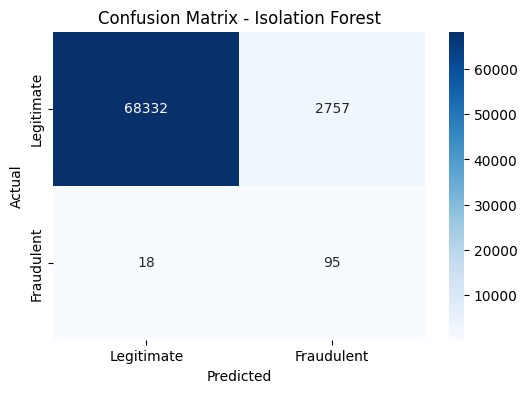

In [7]:
# We'll train on all X_train ignoring y_train,
# then compare outlier predictions to y_test.
iso_pipe = Pipeline([
    ('logscale', LogAndScaleTransformer(drop_original_amount=True)),
    ('iso', IsolationForest(
        n_estimators=100,
        n_jobs=-1,
        contamination='auto',
        random_state=42
    ))
])

iso_pipe.fit(X_train)  # unsupervised
iso_outliers = iso_pipe['iso'].predict(iso_pipe['logscale'].transform(X_test))
iso_preds = np.where(iso_outliers == -1, 1, 0)

print("=== Isolation Forest ===")
cm_iso = confusion_matrix(y_test, iso_preds)
print(cm_iso)
print(classification_report(y_test, iso_preds, digits=4))

plt.figure(figsize=(6,4))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate','Fraudulent'],
            yticklabels=['Legitimate','Fraudulent'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Isolation Forest')
plt.show()